In [57]:
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report , accuracy_score , confusion_matrix , precision_score , f1_score
import networkx as nx

import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GCNConv #GATConv
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx , from_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [82]:
def my_classification_report(y_actual , y_pred):
    """
    Description : 
    - This function takes precdicted and actual values and gives key classification metrics
    
    Inputs:
    1. y_actual : Array of actual labels
    2. y_pred :  Array of predicted labels
    
    Outputs:
    1. Prescision , recall, F1-Score and Accuracy metrics
    2. Plot of confusion matrix
    """
    
    print(classification_report(y_actual, y_pred))
    acc = accuracy_score(y_actual , y_pred)
    print('accuracy : {}'.format(acc))
   
    conf_mat=confusion_matrix(y_actual, y_pred)
    print(conf_mat)

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


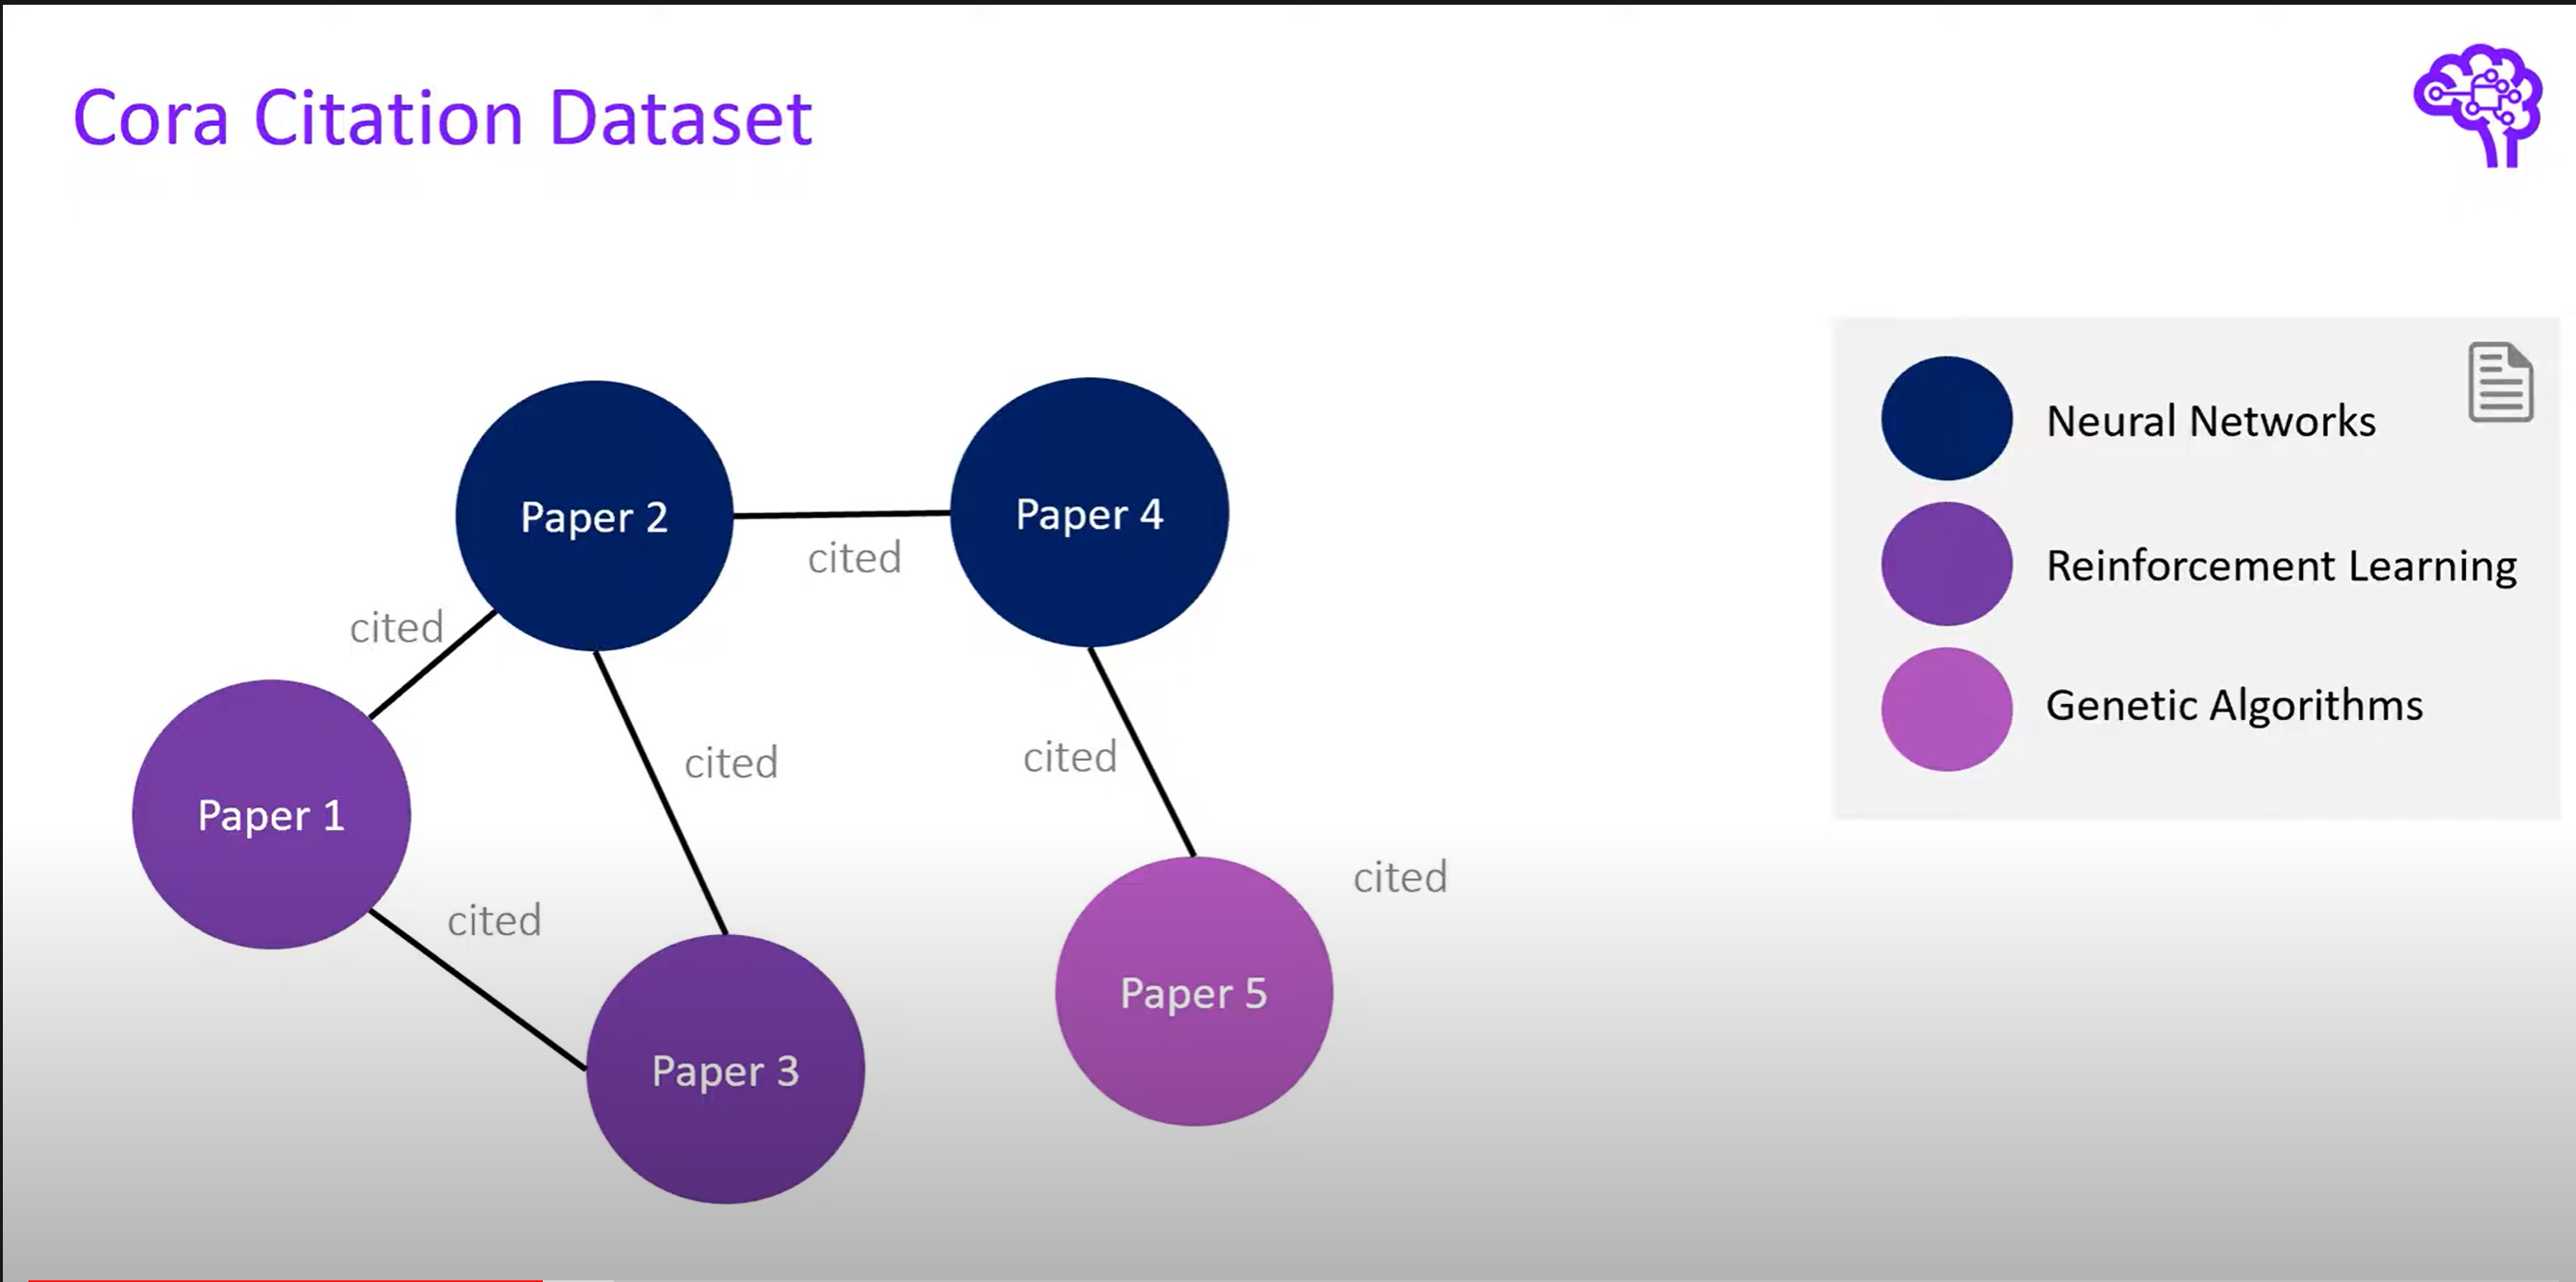

In [34]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [35]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [36]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [37]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [38]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [39]:
data.x.shape

torch.Size([2708, 1433])

In [62]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=128)
print(model)

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 128)
  (out): Linear(in_features=128, out_features=7, bias=True)
)


In [63]:
# Initialize model
model = GCN(hidden_channels=64)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

cuda:0


In [64]:
def train():
    model.train()
    optimizer.zero_grad() 
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)  
    # Only use nodes with labels available for loss calculation --> mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward() 
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # Use the class with highest probability.
    pred = out.argmax(dim=1)  
    # Check against ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return pred , test_acc

In [65]:
losses = []
start_time = time.time()
for epoch in range(0, 2001):
    loss = train()
    losses.append(loss)
    if epoch % 200 == 0:
        print('Epoch: {}, Loss: {} , Time : {} secs'.format(epoch , loss , round(time.time() - start_time , 2)))
        start_time = time.time()

Epoch: 0, Loss: 1.945961594581604 , Time : 0.13 secs
Epoch: 200, Loss: 1.2611536979675293 , Time : 4.81 secs
Epoch: 400, Loss: 1.2241952419281006 , Time : 4.3 secs
Epoch: 600, Loss: 1.2124096155166626 , Time : 4.36 secs
Epoch: 800, Loss: 1.2027983665466309 , Time : 4.35 secs
Epoch: 1000, Loss: 1.2085927724838257 , Time : 4.42 secs
Epoch: 1200, Loss: 1.2158174514770508 , Time : 4.38 secs
Epoch: 1400, Loss: 1.1976265907287598 , Time : 4.33 secs
Epoch: 1600, Loss: 1.1997929811477661 , Time : 4.41 secs
Epoch: 1800, Loss: 1.2116413116455078 , Time : 4.35 secs
Epoch: 2000, Loss: 1.2076278924942017 , Time : 4.39 secs


d:\installed_softwares\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

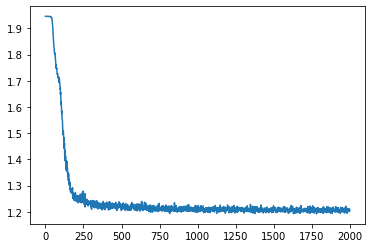

In [66]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [83]:
my_classification_report(y_actual = data.y[data.test_mask].detach().cpu().numpy()
                         , y_pred = pred[data.test_mask].detach().cpu().numpy())

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       130
           1       0.70      0.86      0.77        91
           2       0.89      0.86      0.87       144
           3       0.88      0.79      0.83       319
           4       0.70      0.80      0.74       149
           5       0.80      0.78      0.79       103
           6       0.73      0.81      0.77        64

    accuracy                           0.79      1000
   macro avg       0.77      0.79      0.78      1000
weighted avg       0.80      0.79      0.79      1000

accuracy : 0.791
[[ 87   8   2  10  12   3   8]
 [  3  78   5   3   0   1   1]
 [  2   9 124   6   3   0   0]
 [  7  10   5 251  37   8   1]
 [ 11   5   0   9 119   3   2]
 [  6   1   4   5   0  80   7]
 [  5   0   0   2   0   5  52]]
